# Painting OM10 Lens Systems with Synthetic Colors

_Jenny Kim, Phil Marshall_

The OM10 mock lensed quasar catalog `qso_mock.fits` contains estimates of the lens galaxy $i$-band magnitudes, based on a simple Faber-Jackson scaling. With the `lenspop` library we can compute synthetic magnitudes in any filter. In this notebook we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $g-r$ magnitude, 4) $r-i$ magnitude, and 5) $i-z$ magnitude when:

- comparing the synthetic magnitudes of the colored OM10 lens galaxies with those of SDSS LRGs

- comparing the synthetic magnitudes of colored OM10 lens galaxies with those of 56 candidate galaxy-scale lenses that were  imaged as part of the Canada-France-Hawaii Telescope (CFHT) Legacy Survey

- comparing the synthetic magnitudes of colored OM10 lensed quasars with those of known SDSS Quasars


### Requirements
`om10`, `qso_mock.fits`, and `om10`'s dependencies:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os, matplotlib, numpy as np
import om10, corner
from om10 import plotting
from __future__ import division
from astropy.table import Table
from astropy.io import ascii
import pandas as pd
sns.set()

/Users/Jenny/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Jenny/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

We first have to load the om10 catalog and select 200 random lenses. 

Then, using the `paint` method, we color those lenses synthetically.

In [3]:
%%capture
db = om10.DB('../data/qso_mock.fits')
db.select_random(Nlens=200)
db.paint(synthetic=True)

In [4]:
db.sample

LENSID,FLAGTYPE,NIMG,ZLENS,VELDISP,ELLIP,PHIE,GAMMA,PHIG,ZSRC,XSRC,YSRC,MAGI_IN,MAGI,IMSEP,XIMG [4],YIMG [4],MAG [4],DELAY [4],KAPPA [4],FSTAR [4],DD,DDLUM,ABMAG_I,APMAG_I,KCORR,DS,DDS,SIGCRIT,DSLUM,L_I,REFF,REFF_T,weight,r_SDSS_lens,g_SDSS_lens,i_SDSS_lens,z_SDSS_lens,u_SDSS_lens,r_SDSS_quasar,g_SDSS_quasar,i_SDSS_quasar,z_SDSS_quasar,u_SDSS_quasar
int32,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
21915968,0,2,0.872,243.7811,0.4166908,157.3284,0.05138552,-127.9897,2.38,-0.2803844,0.03013488,23.37,22.39527,1.695001,-1.1274 .. 0.0,0.1666 .. 0.0,2.4541 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1592.09705,5579.31885,-23.2614784,21.3434277,0.871999979,1681.73,799.953,0.0,19212.8,0.0,0.0,0.0,1.0,20.5061413221,23.2967394111,19.269814008,18.0883108104,24.8744078491,23.4058219872,23.5047168991,23.37,23.1543532364,23.9905469479
13089569,0,2,0.704,299.9163,0.1409195,5.194774,0.05411495,59.96758,1.96,0.2889954,0.4423004,22.21,21.55583,2.814393,-0.3703 .. 0.0,-0.768 .. 0.0,-1.8267 .. 0.0,203.173 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1477.22681,4289.29932,-23.6790791,20.1868534,0.703999996,1730.18,879.772,0.0,15159.1,0.0,0.0,0.0,1.0,18.8753963646,20.8744560995,17.3562939063,16.682706854,23.3189600353,22.4038788009,22.4896473666,22.21,22.083104371,22.5527370717
7396451,0,2,0.562,239.3316,0.248686,149.0644,0.05182742,118.6895,1.61,-0.02747283,-0.4378694,21.25,21.52815,1.797131,0.3086 .. 0.0,-1.3549 .. 0.0,2.6456 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1336.60071,3261.09717,-22.9806576,20.1481609,0.561999977,1747.5,947.586,0.0,11904.1,0.0,0.0,0.0,1.0,19.4272461947,21.2401383106,18.1938439865,17.650237754,24.0708434176,21.4597163024,21.5749409211,21.25,21.2485538416,21.6534189368
21334928,0,2,0.862,261.2161,0.1619905,82.98969,0.07776497,-86.38765,2.62,-0.2164059,-0.4623513,23.27,22.98239,2.159355,-0.419 .. 0.0,-1.5934 .. 0.0,2.1592 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1586.53235,5500.57764,-23.4351768,21.1288643,0.861999989,1647.4,831.343,0.0,21588.2,0.0,0.0,0.0,1.0,20.139185122,22.903338968,18.9003193454,17.7317986568,24.5106725384,23.3069628272,23.5078562369,23.27,23.0919625959,24.2774595367
875404,0,2,0.256,263.0268,0.3629871,24.51018,0.02979226,10.94002,0.99,-0.453857,0.2643312,22.51,22.64093,2.591491,0.5253 .. 0.0,-0.5721 .. 0.0,-0.8864 .. 0.0,63.408 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,820.640564,1294.59021,-22.9988003,17.8178616,0.256000012,1647.87,1129.91,0.0,6525.73,0.0,0.0,0.0,1.0,16.9634568873,18.5695391582,16.3922501176,16.1024954168,20.0660311561,22.4813678149,22.6904413953,22.51,22.3653678101,22.7837148131
19727502,0,2,0.834,236.592,0.3383611,23.85537,0.1042971,30.66827,2.71,-0.267057,-0.2815543,23.15,22.70977,1.873927,-1.1652 .. 0.0,-0.8456 .. 0.0,1.8392 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1570.16199,5281.32764,-23.1544609,21.2932549,0.833999991,1633.8,857.611,0.0,22487.8,0.0,0.0,0.0,1.0,20.5280455351,23.1797295366,19.259204028,18.1716581315,24.9005817358,23.208730785,23.4458963073,23.15,23.0462977163,24.2401182329
9905370,0,2,0.63,252.9298,0.4183779,-15.24689,0.02686023,-121.2741,2.44,0.1373078,-0.1353078,21.83,21.02337,1.968085,1.2299 .. 0.0,-0.5688 .. 0.0,2.9803 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1409.81836,3745.74634,-23.1766186,20.3210716,0.629999995,1673.45,1005.43,0.0,19802.9,0.0,0.0,0.0,1.0,19.4635794209,21.3552109473,18.0929257077,17.5120813676,24.1039350973,21.8498259715,21.9825853025,21.83,21.6032059184,22.7078528811
1141965,0,2,0.282,190.1078,0.4508649,84.78147,0.06334625,91.49858,1.82,-0.1567849,-0.4270983,22.03,21.672,1.773738,-0.2807 .. 0.0,-1.3807 .. 0.0,1.7062 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,879.79718,1445.9679,-22.1666603,18.916132,0.282000005,1740.61,1340.64,0.0,13842.0,0.0,0.0,0.0,1.0,18.6773062998,20.3589332771,18.07

## 1 Comparing the Lens Galaxy Synthetic Photometry with SDSS LRGs

We will overlap the colored lenses with the SDSS LRGs on the cornerplot. The SDSS LRG data is saved in `../data/SDSS_LRGs.txt`. The file has these following columns : `ra  dec  z  mag_u  mag_g  mag_r  mag_i  mag_z`.

In [5]:
table = np.loadtxt('../data/SDSS_LRGs.txt')
zReal = table[:,2]
iReal = table[:,6]
grReal = table[:,4]-table[:,5]
riReal = table[:,5]-table[:,6]
izReal = table[:,6]-table[:,7]

Before putting all of the real and mock lenses directly onto the cornerplot, we need to weight the mocked lenses with respect to the parent(LRG) population. We approximate the redshifts of the parent population to be Gaussian distributed with the population mean and standard deviation.

The weights were calculated using the following formula:

$ w_k = \frac { P(z_k) }{ Q(z_k) } $

where $P(z_k)$ is the value of the histogram of redshifts in the parent distribution at the $k^{th}$ redshift, and $Q(z_k)$ is the value of the histogram of mock, colored lenses's redshifts at the $k^{th}$ redshift. These weights were used in a rejection sampling, to make the distribution more like its gaussian population distribution. This reweighting algorithm is implemented in the method `db.gaussian_reweight()`.

In [6]:
%%capture
db.gaussian_reweight(np.mean(zReal), np.std(zReal))
# calculating the color index for g-r, r-i, and i-z
gr = db.sample['g_SDSS_lens'] - db.sample['r_SDSS_lens']
ri = db.sample['r_SDSS_lens'] - db.sample['i_SDSS_lens']
iz = db.sample['i_SDSS_lens'] - db.sample['z_SDSS_lens']

Then, we draw the cornerplot with the synthetically colored OM10 lenses and save to the argument `fig1`.  Then, we will overlap this `fig` with the original data. Ideally, the distributions of the data should look similar, and the blue contours and the red contours should have significant overlap.

In [7]:
%%capture
matplotlib.rc('text', usetex=False)
# save the syntheticall colored OM10 lenses' cornerplot to fig1
data = Table({'i_SDSS': db.sample['i_SDSS_lens'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

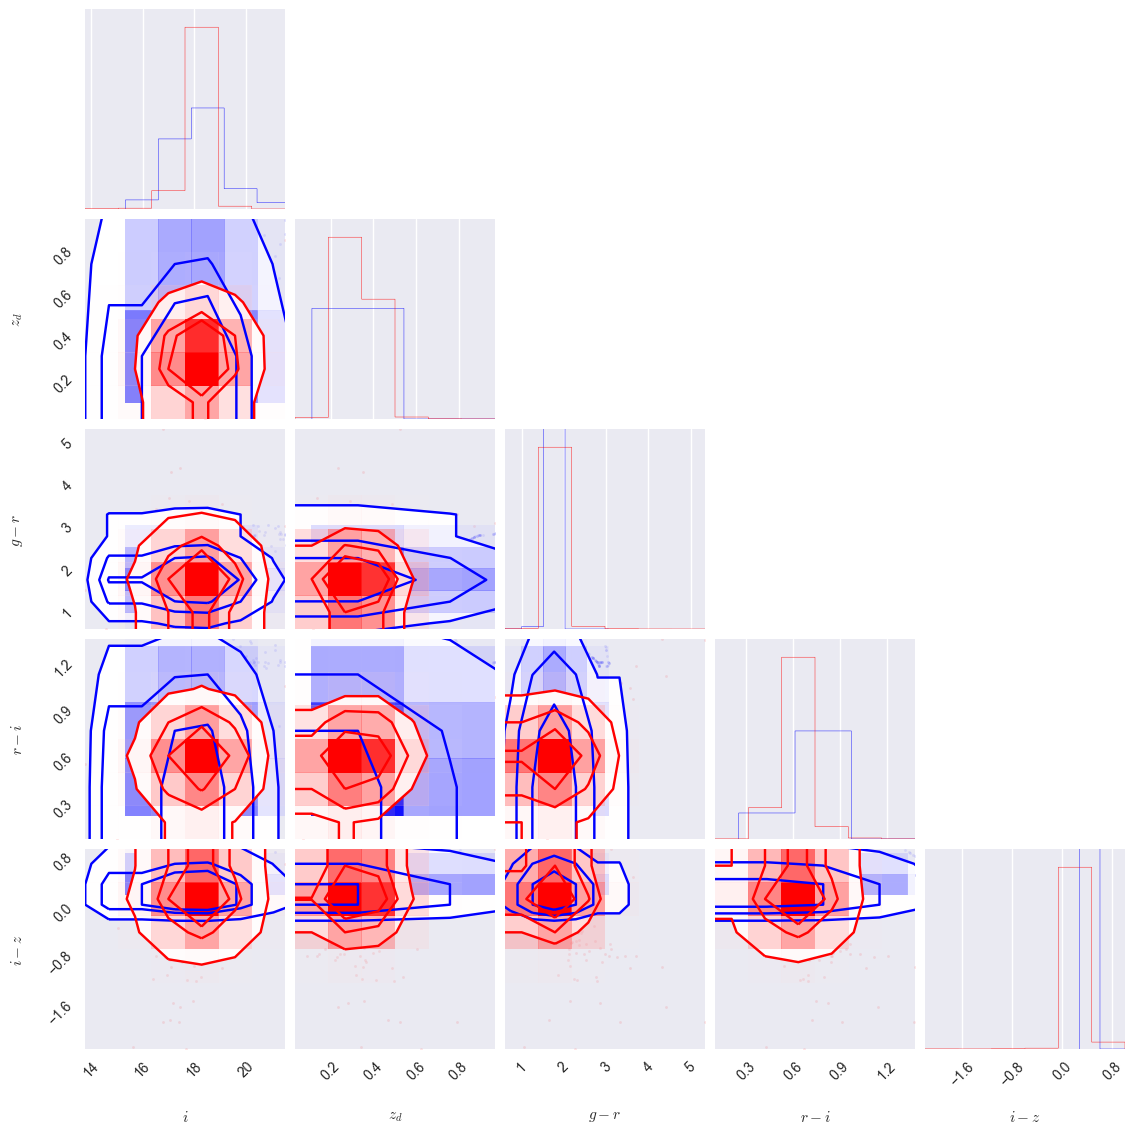

In [8]:
# overlay fig1 with the real distribution
data = Table({'i_SDSS': iReal, 'ZLENS': zReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig1, hist_kwargs=dict(normed=True), hist2d_kwarge=dict(alpha=0.5))

## 2 Comparing the Lens Galaxy Synthetic Photometry with SL2S Lens Galaxies

In two papers, [Sonnenfeld et al (2014)](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/97/meta#apj485108t5) and [Sonnenfeld et al (2015)](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/98/meta) provide photometric measurements of 56 SL2S galaxy-scale lenses that were taken with Canada-France-Hawaii Telescope (CFHT). We can compare the distributions of magnitude, redshift and color between the OM10 lens galaxies (as painted above) and the SL2S lens galaxies. 

> CFHT magnitudes and SDSS magnitudes are different by just $~0.05 mag$; for the sake of simple calculation, we ignore thses small differences in this notebook.

We scraped the lens galaxy photometry and redshifts from the above papers into three datafiles. All the files contain LensName, which we used to match the data of the same lens systems in different datafiles. The second cell below merges all the information needed.

In [9]:
III_a = np.genfromtxt('../data/SonnenfeldTable1.txt', dtype=str, usecols = (0, 4, 5, 6, 7, 8), invalid_raise=False, missing_values='xxx', usemask=False)
III_b = np.genfromtxt('../data/SonnenfeldTable2.txt', dtype=str, usecols = (0, 1), invalid_raise=False, missing_values='xxx')
IV = np.genfromtxt('../data/SonnenfeldTable3.txt', dtype=str, usecols = (0, 11), invalid_raise=False, missing_values='xxx')

/Users/Jenny/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: ConversionWarning: Some errors were detected !
    Line #7 (got 1 columns instead of 2)
    Line #36 (got 1 columns instead of 2)
    Line #41 (got 1 columns instead of 2)
    Line #45 (got 1 columns instead of 2)
  from ipykernel import kernelapp as app
/Users/Jenny/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: ConversionWarning: Some errors were detected !
    Line #12 (got 11 columns instead of 2)
    Line #41 (got 11 columns instead of 2)
    Line #49 (got 11 columns instead of 2)
    Line #66 (got 11 columns instead of 2)
    Line #71 (got 11 columns instead of 2)
  app.launch_new_instance()


In [10]:
name = np.array([])
redshiftReal = np.array([])
iReal = np.array([])
grReal = np.array([])
riReal = np.array([])
izReal = np.array([])
for (lensName, aIndex) in zip(III_a[:,0], range(len(III_a))):
    if lensName in III_b[:,0]:
        bIndex = np.argwhere(III_b[:,0]==lensName)[0][0]
        if lensName in IV[:,0]:
            VIndex = np.argwhere(IV[:,0]==lensName)[0][0]
            # the redshift sometimes has some problem, so we should handle those problems
            if(IV[VIndex][1].isdigit()):
                name = np.append(name, lensName)
                redshiftReal = np.append(redshiftReal, float(III_b[bIndex][1]))
                iReal = np.append(iReal, float(III_a[aIndex][4]))
                grReal = np.append(grReal, float(III_a[aIndex][2]) - float(III_a[aIndex][3]))
                riReal = np.append(riReal, float(III_a[aIndex][3]) - float(III_a[aIndex][4]))
                izReal = np.append(izReal, float(III_a[aIndex][4]) - float(III_a[aIndex][5]))
#convert every numpy array to list - if not, OM10.plot_sample throws an error
redshift = np.array(redshiftReal.tolist())
iReal = np.array(iReal.tolist())
grReal = np.array(grReal.tolist())
riReal = np.array(riReal.tolist())
izReal = np.array(izReal.tolist())
from astropy.table import Table
data = Table({'MAGI': iReal, 'ZLENS': redshiftReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['MAGI', 'ZLENS', 'GR', 'RI', 'IZ'])

We only have around 35 real lenses to use to weight the mock lenses. While this is not a large sample, we can still plot the synthetically colored lenses after reweighting the mock lenses to match the real lens redshift distribution. Ideally, the distributions of the data should be similar, and the blue contours and the red contours should have significant overlap.

In [11]:
%%capture
db.gaussian_reweight(np.mean(redshift), np.std(redshift))
matplotlib.rc('text', usetex=False)
# GR Color index
gr = db.sample['g_SDSS_lens'] - db.sample['r_SDSS_lens']
ri = db.sample['r_SDSS_lens'] - db.sample['i_SDSS_lens']
iz = db.sample['i_SDSS_lens'] - db.sample['z_SDSS_lens']
data = Table({'i_SDSS': db.sample['i_SDSS_lens'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))

fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

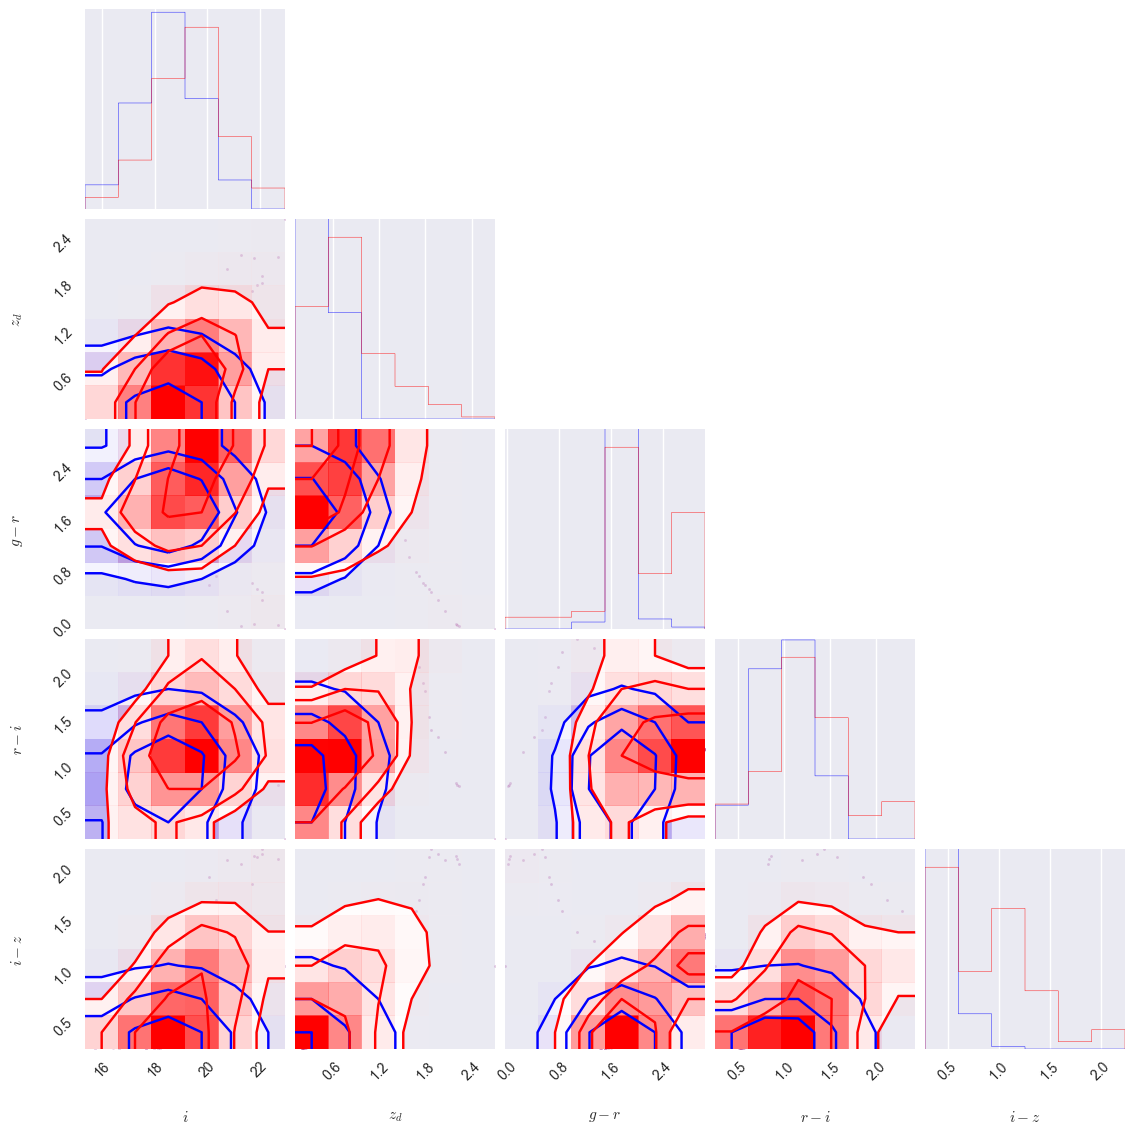

In [12]:
%matplotlib inline
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig1, hist_kwargs=dict(normed=True))

## 3 Comparing the Lensed Quasar Synthetic Photometry with SDSS Quasars

The last comparison that we make is with the lensed sources. [This file](https://raw.githubusercontent.com/KIPAC/StatisticalMethods/master/examples/SDSScatalog/data/qso10000.csv) contains magnitudes and redshifts for 10,000 SDSS quasars. We will compare the synthetically colored OM10 lensed quasars with this data. The processes are the same as the above.

In [13]:
# Read the data
pd.set_option('display.max_columns', None)
qsos = pd.read_csv("https://raw.githubusercontent.com/KIPAC/StatisticalMethods/master/examples/SDSScatalog/data/qso10000.csv",index_col=0)
# Clean out extreme colors and bad magnitudes:
qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10) & (qsos["mag_i"]<23.6)]
qso = qsos.as_matrix()

matplotlib.rc('text', usetex=False)
zReal = qsos["spec_z"].as_matrix()

In [14]:
db.gaussian_reweight(np.mean(zReal), np.std(zReal))
matplotlib.rc('text', usetex=False)
# calculating the color index for g-r, r-i, and i-z
gr = db.sample['g_SDSS_quasar'] - db.sample['r_SDSS_quasar']
ri = db.sample['r_SDSS_quasar'] - db.sample['i_SDSS_quasar']
iz = db.sample['i_SDSS_quasar'] - db.sample['z_SDSS_quasar']
data = Table({'i_SDSS': db.sample['i_SDSS_quasar'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

In [15]:
iReal = qsos["mag_i"].as_matrix()
grReal = qsos["g_r_color"].as_matrix()
riReal = qsos["r_i_color"].as_matrix()
izReal = qsos["i_z_color"].as_matrix()

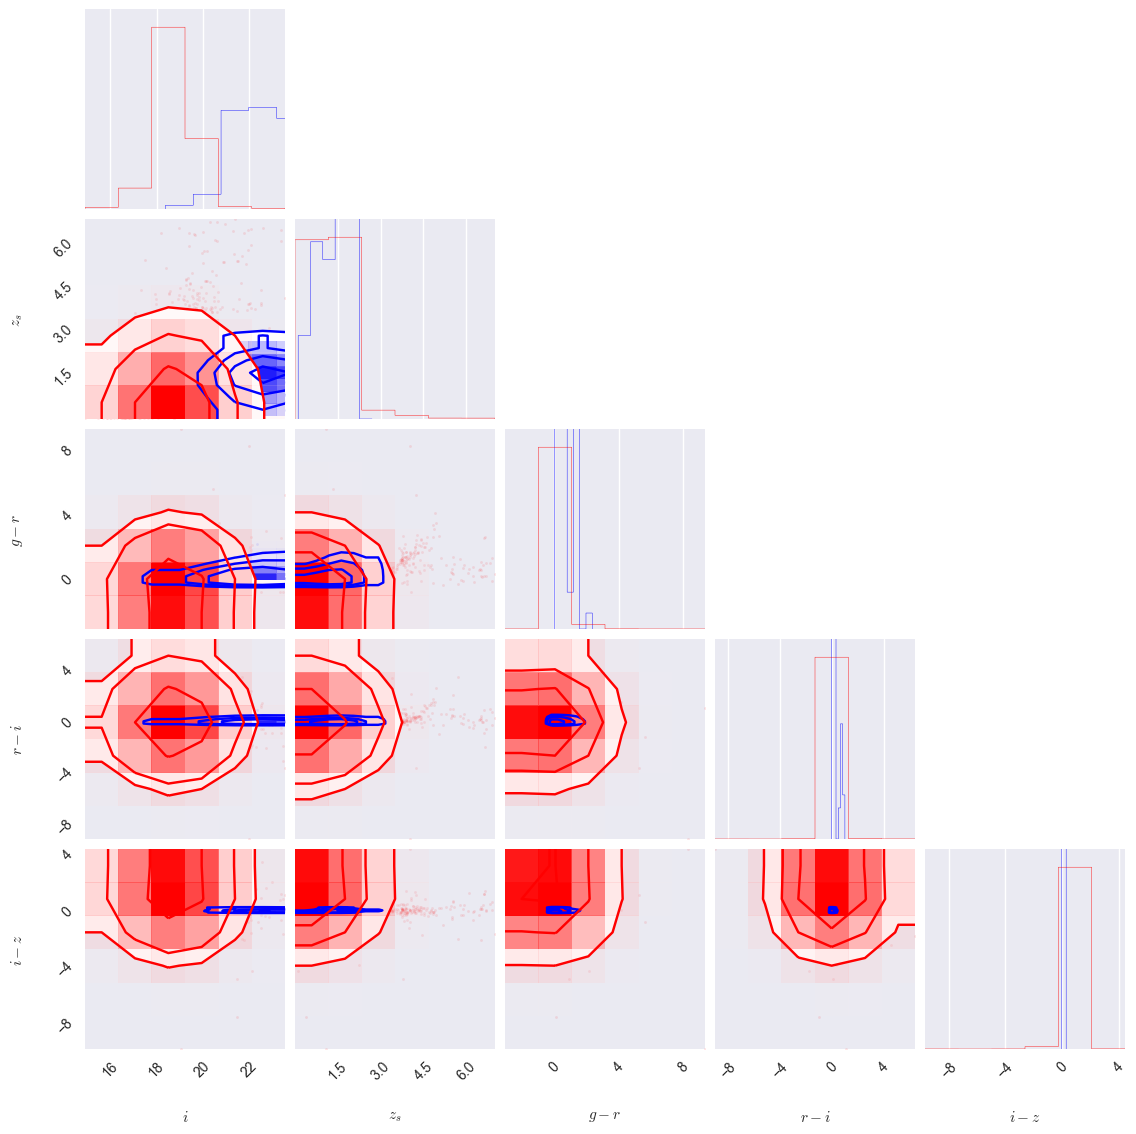

In [16]:
matplotlib.rc('text', usetex=False)
data = Table({'MAGI_Q': iReal, 'ZSRC': zReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['MAGI_Q', 'ZSRC', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('MAGI_Q','ZSRC', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.3, hist_kwargs=dict(normed=True), fig=fig1)

## Discussion

The synthetic magnitude comparisons between OM10 lens galaxies and similarly massive galaxies found as SDSS LRGs and real  CFHTLS lens galaxies show that the `lenspop` synthetic lens galaxy colors are accurate.

> How close are the means and standard deviations in each color? Can we quantify the comparison in terms of being "good to X%"?

However, the $i$-band magnitudes showed some differences in the shape of their distributions. The difference seems to arise from the selection effect present in the SDSS objects: the sample of SDSS LRGs shows a cut in the $u$-band magnitude, which in turn truncates the distribution of `i` band magnitudes.

> What should we do about the lack of scatter in the synthetic quasar colors?

Overall, in this notebook we have show that the synthetic magnitude coloring algorithm in OM10 `paint` method is accurate at the X% level.